<a href="https://colab.research.google.com/github/shuchimishra/Tensorflow_projects/blob/main/Tensorflow_Code/Intro_to_ANN/DigitMNIST_Pixelarray_MultiClass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/shuchimishra/Tensorflow_projects/blob/main/Tensorflow_Code/Intro_to_ANN/Sign_MNIST_MultiClass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-class Classification**

In [1]:
# grader-required-cell

import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
import pandas as pd
from sklearn.model_selection import train_test_split

Download the training and test sets (the test set will actually be used as a validation set):

In [2]:
# !pip install gdown==5.1.0

In [3]:
# # sign_mnist_train.csv
# !gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# # sign_mnist_test.csv
# !gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp -R '/content/drive/MyDrive/Data Science & Machine Learning/Tensorflow Certification/Repository/Tensorflow_projects/Data/DigitRecognizer dataset/' './DigitRecognizer'

Define some globals with the path to both files you just downloaded:

In [6]:
TRAINING_FILE = './DigitRecognizer/train.csv'
TEST_FILE = './DigitRecognizer/test.csv'

In [7]:
#Read the data from CSV files.
train_df=pd.read_csv(TRAINING_FILE)
test_df=pd.read_csv(TEST_FILE)

In [8]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Supporting Functions**

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.fugure_format = 'retina'
def plot_loss_acc(history):
  #-----------------------------------------------------------
  # Retrieve a list of list results on training and test data
  # sets for each training epoch
  #-----------------------------------------------------------
  acc      = history.history[     'accuracy' ]
  val_acc  = history.history[ 'val_accuracy' ]
  loss     = history.history[    'loss' ]
  val_loss = history.history['val_loss' ]
  epochs   = range(len(acc)) # Get number of epochs
  #------------------------------------------------
  # Plot training and validation accuracy per epoch
  #------------------------------------------------
  plt.plot  ( epochs,     acc, label='Training accuracy' )
  plt.plot  ( epochs, val_acc, label='Validation accuracy' )
  plt.title ('Training and validation accuracy')
  plt.grid()
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.figure()
  #------------------------------------------------
  # Plot training and validation loss per epoch
  #------------------------------------------------
  plt.plot  ( epochs,     loss, label='Training loss' )
  plt.plot  ( epochs, val_loss, label='Validation loss' )
  plt.grid()
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title ('Training and validation loss'   )


show_img_dataset(X, y=None, nrows = 4, ncols=4, firstimg=100, numimg=4)

Show images from a dataset. It have a lot of parameters, but just one is obligatory.

Parameters:

X--> The dataset containing the images.
y--> The labels. If informed it will appear below the image.
nrows
ncols
firstimg--> The first img to show, if to big the function fails, I don't check it.
numimg--> The number of images to display.

In [10]:
def show_img_dataset(X, y=None, nrows = 4, ncols=4, firstimg=100, numimg=4):
    for i in range(numimg):
        sp = plt.subplot(nrows, ncols, i + 1)

        sp.axis('Off')
        plt.imshow(X[firstimg+i], cmap="Greys")
        if (y is not None):
            plt.title(y[firstimg+i])
    plt.show()

In [ ]:
#return predictions of the model received.
def get_predictions(model, X, y):
    predictions=model.predict(X)
    results = pd.DataFrame(data={'Predictions': np.argmax(predictions, axis=1),
                            'Actuals': np.argmax(y, axis=1)})
    predictions.shape, y.shape
    return predictions, results

# **Parsing the data**

In [11]:
#Process training data
#Obtain Features and labels.
training_images= train_df.drop('label', axis=1)
training_labels = train_df['label']

training_images.shape, training_labels.shape

((42000, 784), (42000,))

In [12]:
#Process test data
test_images = test_df
test_images.shape

(28000, 784)

In [13]:
#Reshape data
training_images = np.array(training_images).reshape(training_images.shape[0], 28, 28, 1)

test_images = np.array(test_images).reshape((test_images.shape[0], 28, 28, 1))

training_images.shape, test_images.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

## Visualizing the numpy arrays

Now that you have converted the initial csv data into a format that is compatible with computer vision tasks, take a moment to actually see how the images of the dataset look like:

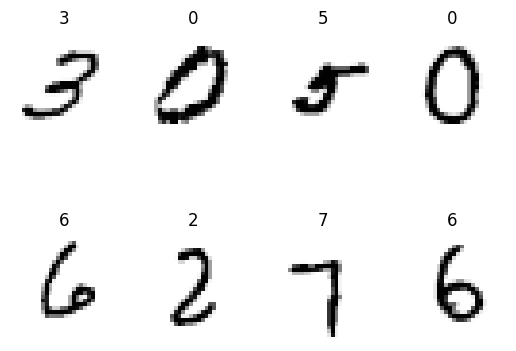

In [14]:
show_img_dataset(training_images,training_labels, firstimg=780, nrows = 2, ncols=4, numimg=8)

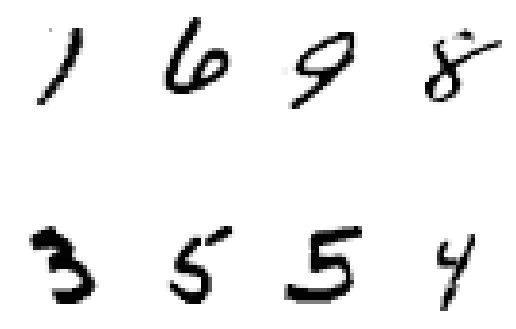

In [15]:
show_img_dataset(test_images, firstimg=780, nrows = 2, ncols=4, numimg=8)

# **Splitting the validation set**

In [16]:
#obtainig from X and y training and validating data.
training_images,validation_images, training_labels, validation_labels = train_test_split(training_images,training_labels, test_size=0.15, random_state=42)

In [17]:
#Check the shapes.
training_images.shape, validation_images.shape, training_labels.shape, validation_labels.shape

((35700, 28, 28, 1), (6300, 28, 28, 1), (35700,), (6300,))

# **Data Augmentation**

In [18]:
# grader-required-cell

# GRADED FUNCTION: train_val_generators
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  """
  Creates the training and test data generators

  Args:
    training_images (array): parsed images from the train CSV file
    training_labels (array): parsed labels from the train CSV file
    validation_images (array): parsed images from the test CSV file
    validation_labels (array): parsed labels from the test CSV file

  Returns:
    train_generator, test_generator - tuple containing the generators
  """

  # Instantiate the ImageDataGenerator class
  # Don't forget to normalize pixel values
  # and set arguments to augment the images (if desired)
  train_datagen = ImageDataGenerator(
      rescale = 1.0/255.0,
      rotation_range=5,
      width_shift_range=0.05,
      height_shift_range=0.05,
      # shear_range=0.2,
      zoom_range=0.1,
      # fill_mode='nearest',
      # horizontal_flip=True,
  )


  # Pass in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32)


  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that test data should not be augmented
  val_datagen = ImageDataGenerator(
      rescale = 1.0/255.0)

  # Pass in the appropriate arguments to the flow method
  val_generator = val_datagen.flow(x=validation_images,
                                   y=validation_labels,
                                   batch_size=32)

  ### END CODE HERE

  return train_generator, val_generator

In [19]:
# grader-required-cell

# Test your generators
train_generator, val_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of test generator have shape: {val_generator.x.shape}")
print(f"Labels of test generator have shape: {val_generator.y.shape}")

Images of training generator have shape: (35700, 28, 28, 1)
Labels of training generator have shape: (35700,)
Images of test generator have shape: (6300, 28, 28, 1)
Labels of test generator have shape: (6300,)


# **Callbacks**

In [ ]:
#just clean the sessio, recomendable if we execute some times the model.
keras.backend.clear_session()

#This callback saves the best model based in val_accuracy
BestModel = tf.keras.callbacks.ModelCheckpoint('modelDA.h5',
                                           mode='max', monitor='val_accuracy',
                                           verbose=1,
                                           save_best_only=True)

# **Build the model**

In [20]:

# grader-required-cell
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop

def create_model():

  ### START CODE HERE

  # Define the model
  # Use no more than 2 Conv2D and 2 MaxPooling2D
  model = keras.models.Sequential([
      keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
      # keras.layers.Conv2D(32, (3,3), activation='relu'),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Conv2D(64, (3,3), activation='relu'),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Flatten(),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dense(26, activation='softmax')
  ])

  ### END CODE HERE

  return model

In [21]:
# Save your model
model = create_model()

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [22]:
model.compile(optimizer = RMSprop(learning_rate=0.001),
                loss = 'sparse_categorical_crossentropy',#NOTE that categorical_crossentropy throws ValueError: Shapes (None, 1) and (None, 26) are incompatible; Refer method to use categorical_crossentropy later in notebook
                metrics=['accuracy'])

In [24]:
# Train your model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=val_generator,
                    callbacks = [BestModel])

Epoch 1/15
1116/1116 [==============================] - 122s 106ms/step - loss: 0.2141 - accuracy: 0.9331 - val_loss: 0.1021 - val_accuracy: 0.9660
Epoch 2/15
1116/1116 [==============================] - 109s 98ms/step - loss: 0.0752 - accuracy: 0.9775 - val_loss: 0.0386 - val_accuracy: 0.9863
Epoch 3/15
1116/1116 [==============================] - 136s 122ms/step - loss: 0.0565 - accuracy: 0.9824 - val_loss: 0.0348 - val_accuracy: 0.9889
Epoch 4/15
1116/1116 [==============================] - 121s 109ms/step - loss: 0.0485 - accuracy: 0.9854 - val_loss: 0.0357 - val_accuracy: 0.9876
Epoch 5/15
1116/1116 [==============================] - 110s 99ms/step - loss: 0.0412 - accuracy: 0.9869 - val_loss: 0.0385 - val_accuracy: 0.9884
Epoch 6/15
1116/1116 [==============================] - 126s 112ms/step - loss: 0.0361 - accuracy: 0.9887 - val_loss: 0.0343 - val_accuracy: 0.9897
Epoch 7/15
1116/1116 [==============================] - 132s 118ms/step - loss: 0.0353 - accuracy: 0.9894 - val_lo

Now take a look at your training history:

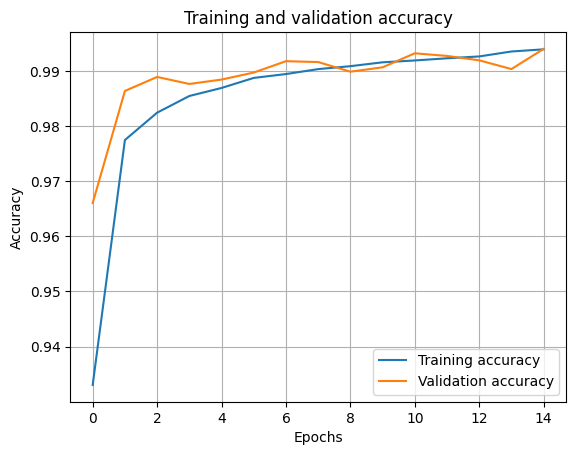

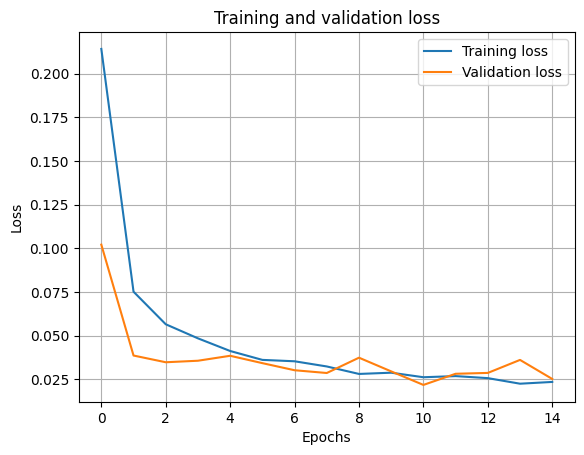

In [25]:
# Plot training results
plot_loss_acc(history)

# **Evaluate results**

In [ ]:
best_model_loaded = load_model('modelDA.h5')

In [ ]:
prediction, results = get_predictions(modelDA_loaded, training_images,training_labels)
results

In [ ]:
validation_loss, validation_accuracy = model.evaluate(training_images,training_labels)
validation_loss_loaded, validation_accuracy_loaded = best_model_loaded.evaluate(training_images,training_labels)
print('Validation loss: ', validation_loss)
print('Validation accuracy: ', validation_accuracy)

print('Validation loss loaded: ', validation_loss_loaded)
print('Validation accuracy loaded: ', validation_accuracy_loaded)

In [ ]:
y_pred=best_model_loaded.predict(test_images)
results = np.argmax(y_pred, axis=1)
results.shape, results

# **[Optional] One hot encoding and categorical crossentropy**

If you want to use **categorical_crossentropy** as loss function, then the labels need to converted to **one hot encoding**; refer code below:

In [ ]:
one_hot_encoded_train_label = tf.one_hot(training_labels, depth = 26) #since we have 26 classes for 26 alphabets
one_hot_encoded_val_label = tf.one_hot(validation_labels, depth = 26) #since we have 26 classes for 26 alphabets

In [ ]:
model.compile(optimizer = RMSprop(learning_rate=0.001),
                loss = 'categorical_crossentropy',
              metrics=['accuracy'])

# **Note that labels passed are one hot encoded**

In [ ]:
# calling the function again to initialize new train and validation augmented datasets

# Test your generators
train_generator_v2, validation_generator_v2 = train_val_generators(training_images, one_hot_encoded_train_label, validation_images, one_hot_encoded_val_label) #note that labels passed are one hot encoded

print(f"Images of training generator have shape: {train_generator_v2.x.shape}") #make sure to pass new dataset with one hot encoded labels i.e, train_generator_v2 (not train_generator)
print(f"Labels of training generator have shape: {train_generator_v2.y.shape}") #make sure to pass new dataset with one hot encoded labels i.e, train_generator_v2 (not train_generator)
print(f"Images of validation generator have shape: {validation_generator_v2.x.shape}") #make sure to pass new dataset with one hot encoded labels i.e, validation_generator_v2 (not validation_generator)
print(f"Labels of validation generator have shape: {validation_generator_v2.y.shape}") #make sure to pass new dataset with one hot encoded labels i.e, validation_generator_v2 (not validation_generator)

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455, 26)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172, 26)


Fitting and evaluating the model again

In [ ]:
history_v2 = model.fit(train_generator_v2,
                    epochs=15,
                    validation_data=validation_generator_v2)

Epoch 1/15
858/858 [==============================] - 14s 11ms/step - loss: 1.4102 - accuracy: 0.5646 - val_loss: 0.4919 - val_accuracy: 0.8281
Epoch 2/15
858/858 [==============================] - 9s 10ms/step - loss: 0.3078 - accuracy: 0.8994 - val_loss: 0.1605 - val_accuracy: 0.9508
Epoch 3/15
858/858 [==============================] - 9s 10ms/step - loss: 0.1168 - accuracy: 0.9619 - val_loss: 0.1135 - val_accuracy: 0.9598
Epoch 4/15
858/858 [==============================] - 9s 10ms/step - loss: 0.0642 - accuracy: 0.9797 - val_loss: 0.1107 - val_accuracy: 0.9646
Epoch 5/15
858/858 [==============================] - 9s 10ms/step - loss: 0.0436 - accuracy: 0.9857 - val_loss: 0.1140 - val_accuracy: 0.9746
Epoch 6/15
858/858 [==============================] - 9s 10ms/step - loss: 0.0297 - accuracy: 0.9905 - val_loss: 0.0671 - val_accuracy: 0.9755
Epoch 7/15
858/858 [==============================] - 9s 10ms/step - loss: 0.0223 - accuracy: 0.9923 - val_loss: 0.1195 - val_accuracy: 0.969

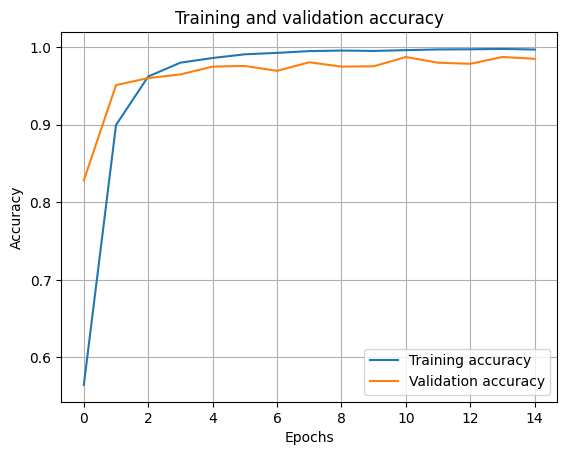

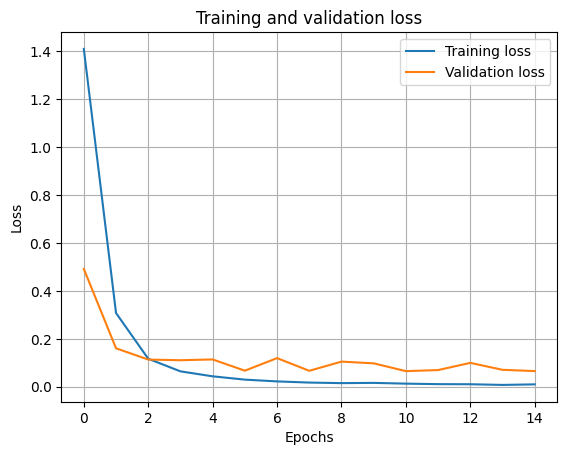

In [ ]:
# Plot training results
plot_loss_acc(history_v2)